# Import package

In [1]:
import os
import pandas as pd
import numpy as np
from root_numpy import root2array 
#---------------------------------------------- JET IMAGE
from root_numpy import root2array, stretch
from pyjet import cluster
from pyjet.testdata import get_event
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import glob
import matplotlib.cm as cm
from scipy.stats import binned_statistic_2d
from matplotlib.colors import LogNorm
#--------------------------------- ALL
import h5py 
import uproot
import time
#-------------------------------- JSS
import pyjet
import argparse
import glob
import math
import operator
import os
import re
import time
from functools import lru_cache, reduce
from itertools import combinations

import numpy as np
import pandas as pd


Welcome to JupyROOT 6.20/04


$ pip3 install tqdm
$ pip3 install pyjet
$ pip3 install scipy
$ pip3 install h5py

$ cd <path_to_your_root_file>
$　root XXX.root
[root] _file0->ls()
[root] Delphes->MakeClass()

In [166]:
def cluster_event(event_list):
    event_list_clustered = []
    for x in range(len(event_list)):
        to_cluster = np.array([event_list[x][:,0],event_list[x][:,1],event_list[x][:,2],event_list[x][:,3]])
        to_cluster = np.swapaxes(to_cluster,0,1)
        to_cluster = np.core.records.fromarrays(to_cluster.transpose(), 
                                             names='pT, eta, phi, mass',
                                             formats = 'f8, f8, f8,f8')
        sequence_cluster = cluster(to_cluster, R = 0.8,p = -1)
        jets_cluster = sequence_cluster.inclusive_jets()
        event_list_clustered.append(jets_cluster)
    return(event_list_clustered)

# Define function for jet image

In [225]:

def flatten(event): #my update
    fp = np.concatenate((np.expand_dims(event[0], axis=-1),
                         np.expand_dims(event[1], axis=-1),
                         np.expand_dims(event[2], axis=-1),
                         np.expand_dims(event[3], axis=-1)), axis=-1)
    fp = fp.transpose((1,0))
    fp = np.core.records.fromarrays( [fp[:][0],fp[:][1],fp[:][2],fp[:][3]], names= 'pT, eta, phi, mass' , formats = 'f8, f8, f8,f8')

    return fp
## Taylor's root to jet image code
def root_2_jets(root_file):
    # Takes root_file as produces a jet-image
#     events = root2array(root_file, "Delphes;1", branches=[
#         "Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.E"])

    file = uproot.open(root_file)
    events = np.array([np.array(file["Delphes;1"]["Tower.ET"].array()), #assum E>>m
                       np.array(file["Delphes;1"]["Tower.Eta"].array()),
                       np.array(file["Delphes;1"]["Tower.Phi"].array()),
                       np.array(file["Delphes;1"]["Tower.E"].array())*0   #assume m<<1
                      ])
    events = np.expand_dims(events, axis=-1)
    events = events.transpose((1,0,2))
    events = np.squeeze(events,axis=(2,))

    jet_images = []
    for ix, event in enumerate(tqdm(events)):
        # create trimmed jet event (also centered and rotated)
        event = jet_trimmer(event=event, R0=1.2, R1=0.2, pt_cut=0.03) #paper setting
        

        # pixelize the trimmed jet
        jet_image = pixelize(event)

        # include jet-image as long as it isn't blank
        # blank jets occur only if the event fails a cut
        # during trimming
        if np.sum(jet_image) != 0:
            jet_images.append(jet_image)
            
    return jet_images
def JSS(root_file): #jet substructure
    file = uproot.open(root_file)
    events = np.array([np.array(file["Delphes;1"]["Tower.ET"].array()), #assum E>>m
                       np.array(file["Delphes;1"]["Tower.Eta"].array()),
                       np.array(file["Delphes;1"]["Tower.Phi"].array()),
                       np.array(file["Delphes;1"]["Tower.E"].array())*0  #assume m<<1
                      ])
    events = np.expand_dims(events, axis=-1)
    events = events.transpose((1,0,2))
    events = np.squeeze(events,axis=(2,))

    jss = []
    for ix, event in enumerate(tqdm(events)):
        # create trimmed jet event (also centered and rotated)
        event = jet_trimmer(event=event, R0=0.8, R1=0.4, pt_cut=0.03) #paper setting
        jss.append(event)
            
    return jss

def struc2arr(x):
    # pyjet outputs a structured array. This converts
    # the 4 component structured array into a simple
    # 4xN numpy array
    x = x.view((float, len(x.dtype.names)))
    return x


def rotate(x, y, a):
    xp = x * np.cos(a) - y * np.sin(a)
    yp = x * np.sin(a) + y * np.cos(a)
    return xp, yp


def jet_trimmer(event, R0, R1, pt_cut):
    # R0 = Clustering radius for the main jets
    # R1 = Clustering radius for the subjets in the primary jet
    # pt_cut = Threshold for subjets (relative to the primary jet it's a subjet of)

    trim_pt, trim_eta, trim_phi, trim_mass = [], [], [], []
    
    flattened_event = flatten(event)

#     flattened_event = stretch(event.reshape(-1))
    sequence = cluster(flattened_event, R=R0, p=-1)

    # Main jets
    jets = sequence.inclusive_jets(ptmin=300)
#     print("check")
    # In case we are missing a leading jet, break early
    if len(jets) == 0:
        return np.zeros(1), np.zeros(1), np.zeros(1), np.zeros(1)

    # Take just the leading jet
    jet0 = jets[0]

    # Define a cut threshold that the subjets have to meet (i.e. 5% of the original jet pT)
    jet0_max = jet0.pt
    jet0_cut = jet0_max*pt_cut

    # Grab the subjets by clustering with R1
    subjets = cluster(jet0.constituents_array(), R=R1, p=1)
    subjet_array = subjets.inclusive_jets()

    # Require at least 2 subjets. Otherwise, break early
    if len(subjet_array) <= 1:
        return np.zeros(1), np.zeros(1), np.zeros(1), np.zeros(1)

    for subjet in subjet_array:
        if subjet.pt < jet0_cut:
            # subjet doesn't meet the percentage cut on the original jet pT
            pass
        else:
            # Get the subjets pt, eta, phi constituents
            subjet_data = subjet.constituents_array()
            subjet_data = struc2arr(subjet_data)
            pT = subjet_data[:, 0]
            eta = subjet_data[:, 1]
            phi = subjet_data[:, 2]
            mass = subjet_data[:, 3]

            # Shift all data such that the leading subjet
            # is located at (eta,phi) = (0,0)
            eta -= subjet_array[0].eta
#             eta -= jet0.eta
            phi = np.array( [deltaPhi(i,subjet_array[0].phi) for i in phi])
#             phi = np.array( [deltaPhi(i,jet0.phi) for i in phi])
            

            # Rotate the jet image such that the second leading
            # jet is located at -pi/2
#             s1x, s1y = subjet_array[1].eta, subjet_array[1].phi
            s1x, s1y = subjet_array[1].eta - subjet_array[0].eta, deltaPhi(subjet_array[1].phi,subjet_array[0].phi)
#             s1x, s1y = subjet_array[1].eta - jet0.eta, deltaPhi(subjet_array[1].phi, jet0.phi)
            

            theta = np.arctan2(s1y, s1x)
            if theta < 0.0:
                theta += 2 * np.pi
            eta, phi = rotate(eta, phi, np.pi - theta)

            # Collect the trimmed subjet constituents
            trim_pt.append(pT)
            trim_eta.append(eta)
            trim_phi.append(phi)
            trim_mass.append(mass)
    return np.concatenate(trim_pt), np.concatenate(trim_eta), np.concatenate(trim_phi), np.concatenate(trim_mass)


def pixelize(event):
    pt, eta, phi = event[0], event[1], event[2]

    # Define the binning for the complete calorimeter
#     bins = np.arange(-1.2, 1.2, 0.1)
    bins = 64
    ranges = np.array([[-1.2,1.2],[-1.2,1.2]])

    # Sum energy deposits in each bin
    digitized = binned_statistic_2d(eta, phi, pt, statistic="sum", bins=bins, range= ranges)
#     digitized = binned_statistic_2d(eta, phi, pt, statistic="sum", bins=bins)
    
    jet_image = digitized.statistic
    return jet_image
#-----------------------------------------------------------------------------------------------------------


# Define function for trace

In [20]:
def find_decayratio(event,n, mode = 'daughter'):
    d1, d2 = -1, -1
    d0 = -1
    ID = 4900101 #Xd PID
    for j in  range(len(event[n][0])):
        if(event[n][5][j]==ID)&(event[n][0][j]==23): #23 : hardest outgoing particles
            d1 = event[n][_D1][j]
            d2 = event[n][_D2][j]
            while((event[n][_PID][d1]==ID)or(event[n][5][d2]==ID) ):
                if(event[n][_PID][d1]==ID):
                    d0 = d1
                    d1 = event[n][_D1][d0]
                    d2 = event[n][_D2][d0]
                    if(event[n][_PID][d2]==ID):
                        d0 = d2
                        d1 = event[n][_D1][d0]
                        d2 = event[n][_D2][d0]
                        
    if mode=='daughter':
        return d1, d2
    if mode=='id':
        return event[n][5][d1], event[n][5][d2]
    
def find_subdecayratio(event, n, j, ID=4900111): 
    d1, d2 = -1, -1
    d0 = -1
    d1 = event[n][_D1][j]
    d2 = event[n][_D2][j]
    if((abs(event[n][_PID][d1])!=ID)&(abs(event[n][_PID][d2])!=ID)):
        d1=0
        d2=0
        return d1, d2
    else:
        while((abs(event[n][_PID][d1])==ID)or(abs(event[n][_PID][d2])==ID) ):
            if(abs(event[n][_PID][d1])==ID):
                d0 = d1
                d1 = event[n][_D1][d0]
                d2 = event[n][_D2][d0]
            if(abs(event[n][_PID][d2])==ID):
                d0 = d2
                d1 = event[n][_D1][d0]
                d2 = event[n][_D2][d0]
        return event[n][_PID][d1], event[n][_PID][d2]
def find_daughterid(event, n, j, ID=4900111):
    sid = event[n][_PID][j]
    if(sid!=ID):
        return 0, 0
    else:
        d1 = event[n][_D1][j]
        d2 = event[n][_D2][j]
        return event[n][_PID][d1], event[n][_PID][d2]

def deltaPhi(phi1,phi2):
    x = phi1-phi2
    while x>= np.pi: x -= np.pi*2.
    while x< -np.pi: x += np.pi*2.
    return x        

# Define trimmered leadind jet (Get leading subjet in large R jet )

In [185]:
def jet_trimmer_1J(event, R0, R1, pt_cut):
    # R0 = Clustering radius for the main jets
    # R1 = Clustering radius for the subjets in the primary jet
    # pt_cut = Threshold for subjets (relative to the primary jet it's a subjet of)    
    flattened_event = flatten(event)
    sequence = cluster(flattened_event, R=R0, p=-1)
    # Main jets
    jets = sequence.inclusive_jets(ptmin=300)
    # In case we are missing a leading jet, break early
    if len(jets) == 0:
        return jets

    # Take just the leading jet
    jet0 = jets[0]

    # Define a cut threshold that the subjets have to meet (i.e. 5% of the original jet pT)
    jet0_max = jet0.pt
    jet0_cut = jet0_max*pt_cut

    # Grab the subjets by clustering with R1
    subjets = cluster(jet0.constituents_array(), R=R1, p=1)
    subjet_array = subjets.inclusive_jets()
    if (subjet_array[0].pt >= jet0_cut):
        j0 = subjet_array[0].constituents_array()
        for ij, subjet in enumerate(subjet_array):
            if (ij == 0):
                pass
            if subjet.pt < jet0_cut:
                # subjet doesn't meet the percentage cut on the original jet pT
                pass
            if subjet.pt >= jet0_cut:
                # Get the subjets pt, eta, phi constituents
                subjet_data = subjet.constituents_array()
                j0 = np.append(j0, subjet_data)
    else:
        j0 = subjet_array[0].constituents_array()*0
    sequence = cluster(j0, R=R0, p=-1)
    j0 = sequence.inclusive_jets(ptmin=300)
    return j0

def jet_clustering(event, R0):
    # R0 = Clustering radius for the main jets
    # R1 = Clustering radius for the subjets in the primary jet
    # pt_cut = Threshold for subjets (relative to the primary jet it's a subjet of)    
#     flattened_event = flatten(event)
    sequence = cluster(flattened_event, R=R0, p=-1)
    # Main jets
    jets = sequence.inclusive_jets(ptmin=300)
    # In case we are missing a leading jet, break early
    if len(jets) == 0:
        return jets

    # Take just the leading jet
#     jet0 = jets[0]

    return jet0

In [157]:
j1 = jet_trimmer_1J(events[2], 1.2, 0.2, 0.03)
j1

array([(5.31603754e-01, 4.05907345, 2.2959764 ,  15.39999771),
       (5.28115332e-01, 3.79652667, 2.31978655,  11.76869106),
       (2.36646786e-01, 4.27419329, 2.30759716,   8.49989319),
       (2.80464679e-01, 3.09848785, 2.30850148,   3.11449361),
       (2.05453110e+00, 4.37341881, 2.38186407,  81.48983002),
       (2.20366430e+00, 3.8778584 , 2.42056036,  53.26402283),
       (5.74719131e-01, 4.65254784, 2.42267752,  30.13290405),
       (2.25437546e+00, 4.15383053, 2.44477391,  71.79415894),
       (6.24738634e-01, 2.06285119, 2.4474864 ,   2.49753714),
       (2.09759369e-01, 1.70725024, 2.49605513,   0.59730476),
       (1.54312916e+01, 4.06762123, 2.52556205, 450.86349487),
       (1.53623167e-02, 4.72385454, 2.54459548,   0.86497784),
       (2.13470197e+00, 3.85452843, 2.5260067 ,  50.40835571),
       (1.12822962e+00, 3.91802263, 2.75309205,  28.38669014),
       (3.84363443e-01, 4.2258091 , 2.79424691,  13.15377617),
       (1.38821304e-01, 2.41821694, 2.77964306,   0.785

In [148]:
sequence = cluster(j1, R=1.2, p=-1)  
sequence.inclusive_jets()

[PseudoJet(pt=476.877, eta=-1.099, phi=-1.968, mass=798.889)]

In [145]:
j1

[PseudoJet(pt=337.030, eta=0.333, phi=0.455, mass=620.832)]

# Define Jet variables fumction

In [175]:
def angle(jet, particles):
    ptot2 = (jet.px**2 + jet.py**2 + jet.pz**2) * \
        (particles['px']**2 + particles['py']**2 + particles['pz']**2)
    arg = (jet.px * particles['px'] + jet.py *
           particles['py'] + jet.pz * particles['pz']) / ptot2**(1/2)
    arg[np.isnan(arg)] = 1.0
    arg[arg > 1.0] = 1.0
    arg[arg < -1.0] = -1.0
    return np.arccos(arg)
def t0(jet):
    return sum(p.pt * CalcDeltaR(p, jet) for p in jet.constituents())
def tn(jet, n): #t1 t2 t3 t21 t32
    assert n >= 0
    if n == 0:
        return t0(jet)
    particles = jet.constituents_array()
    if len(particles) < n:
        return -1
    subjets = pyjet.cluster(particles, R=1.0, p=1).exclusive_jets(n)
    subjets_array = [subjet.constituents_array() for subjet in subjets]
    wta_axes = [a[np.argmax(a['pT'])] for a in subjets_array]
    wta_axes = np.array(wta_axes, dtype=subjets_array[0].dtype)
    return np.sum(particles['pT']*CalcDeltaRArray(particles, wta_axes).min(axis=0)) / t0(jet)
def CalcDeltaRArray(p, a):
    dEta = p['eta'] - \
        a['eta'].repeat(p.shape[0]).reshape(a.shape[0], p.shape[0])
    dPhi = np.abs(p['phi'] - a['phi'].repeat(p.shape[0]
                                             ).reshape(a.shape[0], p.shape[0]))
    mask = dPhi > np.pi
    dPhi[mask] *= -1
    dPhi[mask] += 2 * np.pi
    return (dPhi**2 + dEta**2)**0.5


def CalcDeltaR(j1, j2):
    eta1 = j1.eta
    phi1 = j1.phi
    eta2 = j2.eta
    phi2 = j2.phi

    dEta = eta1-eta2
    dPhi = abs(phi1-phi2)
    if dPhi > np.pi:
        dPhi = 2*np.pi - dPhi

    dR = (dPhi**2 + dEta**2)**0.5

    return dR

# energy correlators
# https://arxiv.org/pdf/1411.0665.pdf


def CalcEECorr(jet, n=1, beta=1.0):

    assert n == 2 or n == 3, f'n must be in [2, 3] but is {n}'

    jet_particles = jet.constituents()

    if len(jet_particles) < n:
        return -1

    currentSum = 0

    if n == 2:
        for p1, p2 in combinations(jet_particles, 2):
            # get the terms of the triplet at hand
            pt1 = p1.pt
            pt2 = p2.pt
            dr12 = CalcDeltaR(p1, p2)

            # calculate the partial contribution
            thisterm = pt1*pt2 * (dr12)**beta

            # sum it up
            currentSum += thisterm

        eec = currentSum/(jet.pt)**2

    elif n == 3:
        dr = {(p1, p2): CalcDeltaR(p1, p2)
              for p1, p2 in combinations(jet_particles, 2)}
        for p1, p2, p3 in combinations(jet_particles, 3):
            # get the terms of the triplet at hand
            dr12 = dr[(p1, p2)]
            dr13 = dr[(p1, p3)]
            dr23 = dr[(p2, p3)]

            # calculate the partial contribution
            thisterm = p1.pt*p2.pt*p3.pt * (dr12*dr13*dr23)**beta

            # sum it up
            currentSum += thisterm

        eec = currentSum/(jet.pt)**3
    return eec

def calc_angularity(jet):
    jet_particles = jet.constituents_array(ep=True)

    if jet_particles.shape[0] == 0:
        return -1
    if jet.mass < 1.e-20:
        return -1

    theta = angle(jet, jet_particles)
    e_theta = jet_particles['E'] * np.sin(theta)**-2 * (1 - np.cos(theta))**3

    return np.sum(e_theta) / jet.mass

def calc_KtDeltaR(jet):
    particles = jet.constituents_array()
    if particles.shape[0] < 2:
        return 0.0

    subjets = pyjet.cluster(particles, R=0.4, p=1).exclusive_jets(2)

    return CalcDeltaR(subjets[0], subjets[1])

#

# Jet image

# Load root file for Jet image

In [226]:
#Need to use CMS card to search Fatjet
# root_file = "./SVJ_pythia/QCD_Dijet/ppjj.root" # This is test data: p p -> q q~ (q= u d s)
# root_file = "./SVJ_pythia/QCD_Dijet/ppjj_Altas.root" # This is test data: p p -> j j (j=g u d s u~ d~ s~)
# root_file2 = "./SVJ_pythia/Z1000/delphes_nolhe_Z1000_rinv_04.root" #rinv = 0.3 SVJ
root_file = "/home/james/SVJ_pythia/QCD_SVJ/QCD/QCD.root"
root_file2 = "/home/james/SVJ_pythia/QCD_SVJ/SVJ/delphes_nolhe_Z1500_rinv_03.root"

# root_file2 = "./SVJ_pythia/Nowidth/Z2000/delphes_nolhe_Z2000_rinv_04.root" #rinv = 0.3 SVJ
# root_file2 = "./SVJ_pythia/Nowidth/Z2000/delphes_nolhe_Z2000_rinv_04.root" #rinv = 0.4 SVJ
jet_im2 = root_2_jets(root_file2)
jet_im = root_2_jets(root_file)

100%|██████████| 20000/20000 [00:19<00:00, 1013.65it/s]


# Plot jet image

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


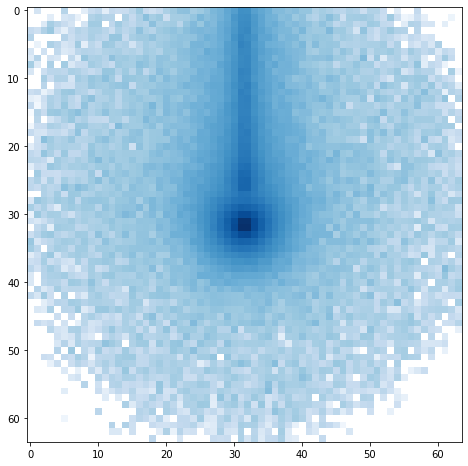

In [227]:
jet_im= np.array(jet_im)
plt.figure(figsize=(8,8))
X = np.sum(jet_im,axis=0)
plt.imshow(np.log(X), cmap='Blues', label = 'QCD', filternorm=1)
# plt.imshow(X/20000, cmap='Blues', label = 'QCD')

plt.savefig("./jet_image_QCD.png")
plt.show()


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


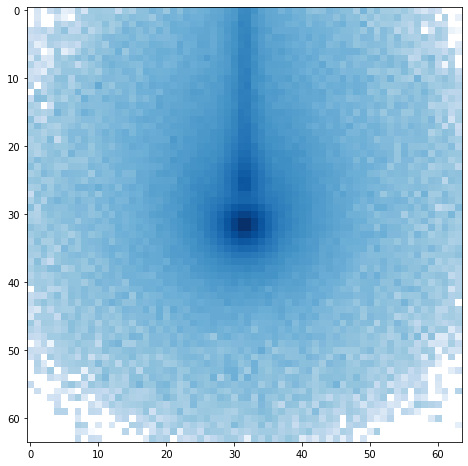

In [228]:
#SVJ 
jet_im2= np.array(jet_im2)
plt.figure(figsize=(8,8))
X2 = np.sum(jet_im2,axis=0)
plt.imshow(np.log(X2), cmap='Blues', label = '$r_{inv}$=0.3' ,filternorm=1)
# plt.imshow(X2/20000, cmap='Blues', label = 'SVJ')
plt.savefig("./jet_image_SVJ_Z1500_rinv_03.png")
plt.show()

# Save jet image as h5

In [14]:
hf = h5py.File('./QCD_Dijet_ppqq.h5', 'w')
hf.create_dataset('dataset_1', data=jet_im)
hf.close()

# JSS

# Load root file for JSS variable

In [238]:
## for trimmed leadind jet
root_file = "/home/james/SVJ_pythia/QCD_SVJ/QCD/QCD.root"
file = uproot.open(root_file)
# events = np.array([np.array(file["Delphes;1"]["Tower.ET"].array()),
#                    np.array(file["Delphes;1"]["Tower.Eta"].array()),
#                    np.array(file["Delphes;1"]["Tower.Phi"].array()),
#                    np.array(file["Delphes;1"]["Tower.E"].array())*0  #assume m<<1
#                   ])
events = np.array([np.array(file["Delphes;1"]["Tower.ET"].array()),
                   np.array(file["Delphes;1"]["Tower.Eta"].array()),
                   np.array(file["Delphes;1"]["Tower.Phi"].array()),
                   np.array(file["Delphes;1"]["Tower.E"].array())*0  #assume m<<1
                  ])

events = np.expand_dims(events, axis=-1)
events = events.transpose((1,0,2))
events = np.squeeze(events,axis=(2,))

root_file2 = "/home/james/SVJ_pythia/QCD_SVJ/SVJ/delphes_nolhe_Z1500_rinv_03.root"
file2 = uproot.open(root_file2)
events2 = np.array([np.array(file2["Delphes;1"]["Tower.ET"].array()),
                   np.array(file2["Delphes;1"]["Tower.Eta"].array()),
                   np.array(file2["Delphes;1"]["Tower.Phi"].array()),
                   np.array(file2["Delphes;1"]["Tower.E"].array())*0  #assume m<<1
                  ])
events2 = np.expand_dims(events2, axis=-1)
events2 = events2.transpose((1,0,2))
events2 = np.squeeze(events2,axis=(2,))


In [224]:
file["Delphes;1"]["Jet.Particles"].array()[0][0]

[1601,
 2200,
 2516,
 2199,
 2367,
 2202,
 2515,
 2374,
 2373,
 1984,
 2371,
 2372,
 2203,
 2369,
 2370,
 1598,
 1589,
 1592,
 1979,
 1981,
 1985]

In [255]:
jet_trimmer_1J(event=events[4], R0=1.2, R1=0.2, pt_cut=0.03)[0]

[PseudoJet(pt=486.056, eta=2.146, phi=-0.235, mass=233.752)]

In [256]:
n=0
for i in range(20000):
    jet0 = jet_trimmer_1J(event=events[i], R0=1.2, R1=0.2, pt_cut=0.03)
    if len(jet0) ==0:
        continue
        
    if jet0[0].pt>=300:
        n=n+1
n

17469

# Calvulate JSS variable by previous function

In [267]:
def JSS_V(events): ##take too long time (about 10 min need to speed up)
#     T1, T2, T3, T21, T22, T32, EE2, EE3, D2, ANGU, KTDEL, PT, ETA, PHI, MASS = [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
    T21, MASS, D21, D22, C21, C22 = [], [], [], [], [], []
    for event in tqdm(events):
        
        
        found_jet = jet_trimmer_1J(event=event, R0=1.2, R1=0.2, pt_cut=0.03)
        if len(found_jet)==0: 
            continue
        
        found_jet = found_jet[0]
#         if (found_jet.pt> 400)or(found_jet.pt<300): # if  I add this condition, I don't have enough jet
#             continue
        if (found_jet.pt> 500)or(found_jet.pt<300): # so I increase upper bound to 600 GeV
            continue
            
#         origin_jet = jet_clustering(event, 1.2)
#         if len(origin_jet)==0: 
#             continue
#         mass = origin_jet.mass - found_jet.mass
        t1 = tn(found_jet, n=1)
        t2 = tn(found_jet, n=2)
#         t3 = tn(found_jet, n=3)
        t21 = t2 / t1 if t1 > 0.0 else 0.0
#         t32 = t3 / t2 if t2 > 0.0 else 0.0
        ee2 = CalcEECorr(found_jet, n=2, beta=1.0)
        ee3 = CalcEECorr(found_jet, n=3, beta=1.0)
        d21 = ee3/(ee2**3) if ee2>0 else 0
        d22 = ee3**2/((ee2**2)**3) if ee2>0 else 0
        c21 = ee3/(ee2**2) if ee2>0 else 0
        c22 = ee3**2/((ee2**2)**2) if ee2>0 else 0
#         angularity = calc_angularity(found_jet)
#         KtDeltaR = calc_KtDeltaR(found_jet)
#         T1.append(t1)
#         T2.append(t2)
#         T3.append(t3)
        T21.append(t21)
#         T32.append(t32)
#         EE2.append(ee2)
#         EE3.append(ee3)
#         D2.append(d2)
#         ANGU.append(angularity)
#         KTDEL.append(KtDeltaR)
#         PT.append(found_jet.pt)
#         ETA.append(found_jet.eta)
#         PHI.append(found_jet.phi)
        MASS.append(found_jet.mass)
#         MASS.append(mass)
        D21.append(d21)
        D22.append(d22)
        C21.append(c21)
        C22.append(c22)
#     return({'T1':T1, 'T2':T2, 'T3':T3, 'T21':T21, 'T22':T22, 'T32':T32, 'EE2':EE2, 'EE3':EE3, 'D2':D2, 'angularity':ANGU,
#             'KtDeltaR':KTDEL, 'PT':PT, 'ETA':ETA, 'PHI':PHI, 'MASS':MASS})
    return({'T21':T21, 'D21':D21, 'MASS':MASS, 'D22':D22, 'C22':C22, 'C21':C21})

In [268]:
jss = JSS_V(events)



100%|██████████| 20000/20000 [00:50<00:00, 396.86it/s]


In [269]:
jss2 = JSS_V(events2)

100%|██████████| 20000/20000 [02:12<00:00, 150.55it/s]


In [129]:
test = []
for event in tqdm(events):
    origin_jet = jet_clustering(event, 0.6 )
    if len(origin_jet)==0: 
        continue
    mass = origin_jet.mass 
    test.append(mass)

100%|██████████| 20000/20000 [00:08<00:00, 2442.20it/s]


In [126]:
test2 = [i[0] for i in file["Delphes;1"]["Jet.Mass"].array() if len(i)>0]

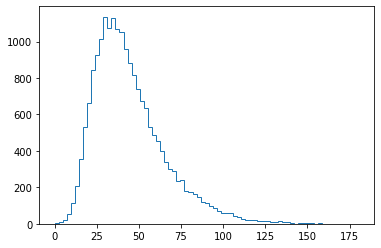

In [127]:
plt.hist(test2 ,bins=bins, histtype='step', label='QCD')
plt.show() 

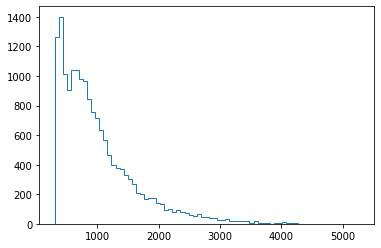

In [130]:
bins = 75
plt.hist(test ,bins=bins, histtype='step', label='QCD')
plt.show() 

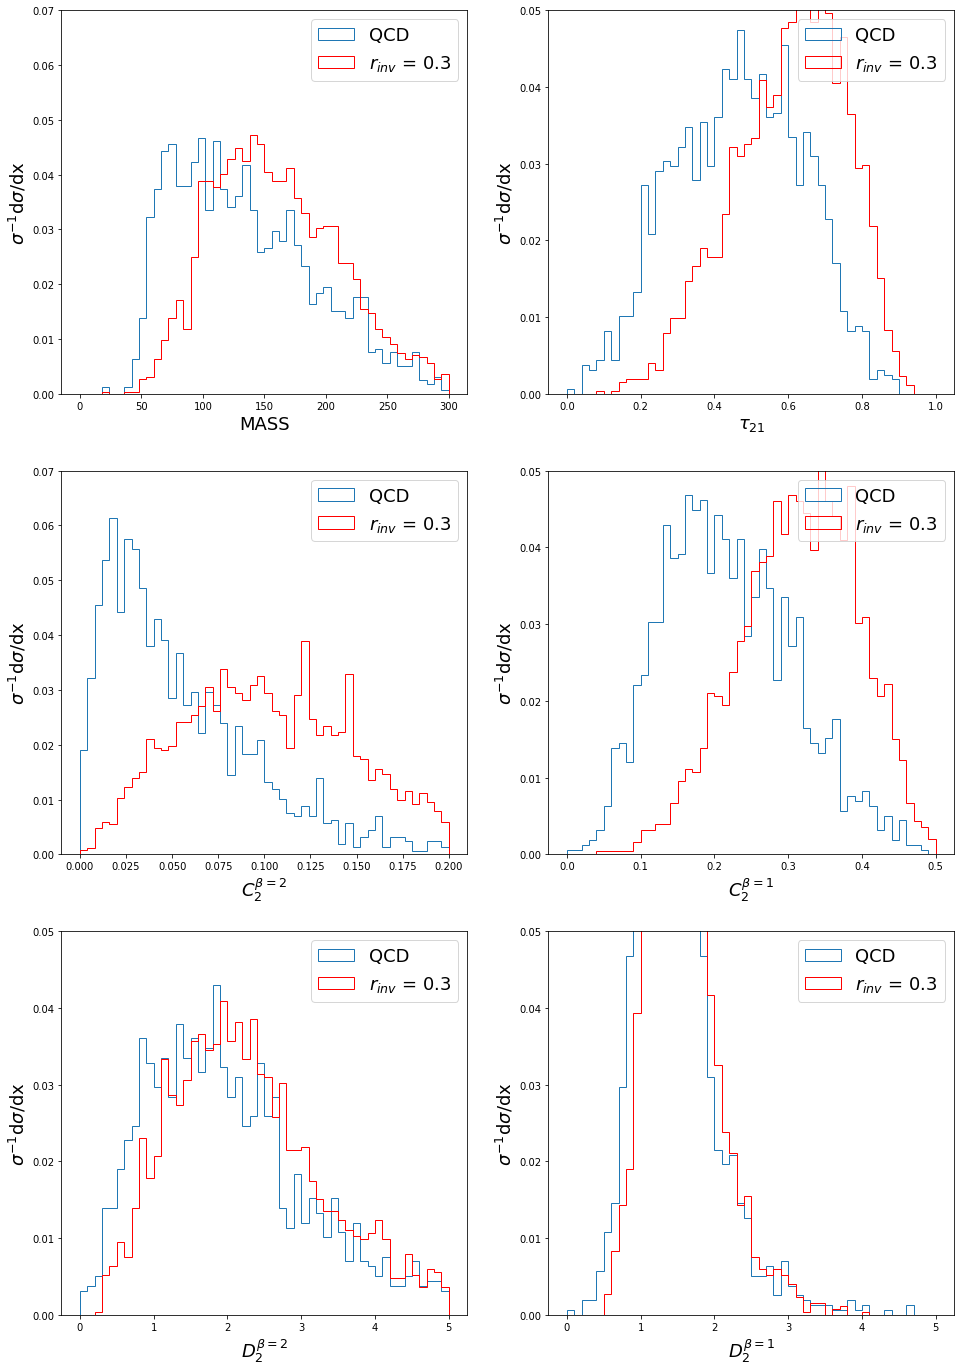

In [271]:
bins = 50
fs=18 # front size
tagsize = 18 # label tag size ((\blue block) W \n (\orange block) QCD )
plt.figure(figsize=(16,24)) # plotsize
x1, x2 = 0, 1

# Labels = ['T1', 'T2', 'T3', 'T21', 'T22', 'T32', 'EE2', 'EE3', 'D2', 'angularity', 'KtDeltaR',
#           'PT', 'ETA', 'PHI', 'MASS']
# Labels = ['T21', 'D21', 'MASS', 'D22', 'C22', 'C21']
Labels = ['MASS', 'T21', 'C22', 'C21',  'D22', 'D21']

# X_Labels = ['${\u03C4_{1}}$', '${\u03C4_{2}}$', '${\u03C4_{3}}$', '${\u03C4_{21}}$', '${\u03C4_{32}}$',
#             'EE2', 'EE3', 'D2', 'angularity', 'KtDeltaR', 'PT', 'ETA', 'PHI', 'MASS']
X_Labels = {'T21':['${\u03C4_{21}}$'], 'D21':['${D_{2}^{\u03B2=1}}$'], 'MASS':['MASS'], 'D22':['$D_{2}^{\u03B2=2}$'], 'C22':['$C_{2}^{\u03B2=2}$'], 'C21':['$C_{2}^{\u03B2=1}$']}

Range = {'T21':[0,1], 'D21':[0,5], 'MASS':[0,300], 'D22':[0,5], 'C22':[0, 0.2], 'C21':[0, 0.5]}
Ylm = {'MASS':[0,0.07], 'T21':[0, 0.05], 'C22':[0,0.07], 'C21':[0,0.05], 'D22':[0, 0.05], 'D21':[0, 0.05]}
for i in range(6):
    W1 = np.array([1 for j in range(len(jss[Labels[i]]))])
    W1 = W1/sum(W1)
    W2 = np.array([1 for j in range(len(jss2[Labels[i]]))])
    W2 = W2/sum(W2)
    plt.subplot(3,2,i+1)
    plt.hist(jss[Labels[i]] ,bins=bins, histtype='step', weights = W1, range=Range[Labels[i]], label='QCD')
    plt.hist(jss2[Labels[i]] ,bins=bins, histtype='step', color='r', weights = W2, range=Range[Labels[i]], label='$r_{inv}$ = 0.3')

    plt.legend(prop={'size': tagsize}) # plot label tag
#     plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel(X_Labels[Labels[i]][0] , fontsize=fs)  # plot x-axis label
    plt.ylabel("${\sigma^{-1}}$d${\sigma}$/dx", fontsize=fs)  # plot y-axis label $\u03C3^{-1}$
    plt.ylim(Ylm[Labels[i]])
    # plt.xlim((x1,x2))

plt.savefig("./JSS_variable_QCD_SVJ.png")  #save figure as png  
plt.show() 



In [237]:
len(W2)

667

# EFP (to be continue...)

$ pip3 install EnergyFlow

In [103]:
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import energyflow as ef
import glob

In [ ]:



def efp(data, efp_ix, kappa, beta):
    if efp_ix == 0:
        normed = False
    else:
        normed = True
    efpset = ef.EFPSet(
        "d<=7", measure="hadr", kappa=kappa, beta=beta, normed=normed, verbose=True
    )
    graph = efpset.graphs(efp_ix)
    EFP_graph = ef.EFP(graph, measure="hadr", kappa=kappa,
                       beta=beta, normed=True)
    X = EFP_graph.batch_compute(data)
    return X


def generate_EFP():
    # Calculate HL variables from ET, eta, phi

    # Load preped data in format [ET, eta, phi]
    df = pd.read_pickle("jet_data_processing/data/prep_data.pkl")
    X = df["features"]
    y = df["targets"]
    # Convert the data from a pandas dataframe to numpy array
    X = X.to_numpy()
    existing_graphs = glob.glob("data/EFP/*.csv")

    # efpset = ef.EFPSet(
    #    "d<=7", measure="hadr", kappa=1, beta=1, normed=True, verbose=True
    # )
    # Compute an EFP from X
    #results = np.asarray([efpset.batch_compute(X)])
    #print(results, results.shape)

    for efp_ix in range(20):
        for kappa in range(-1, 3, 1):
            for beta in range(1, 3, 1):
                file_name = f"data/EFP/efp_{efp_ix}_k_{kappa}_b_{beta}.csv"
                if file_name in existing_graphs:
                    print("skipping " + file_name)
                    pass
                else:
                    print("generating " + file_name)
                    ef_val = efp(data=X, efp_ix=efp_ix, kappa=kappa, beta=beta)
                    efp_df = pd.DataFrame({"features": ef_val, "targets": y})
                    efp_df.to_csv(
                        file_name, compression="gzip")


if __name__ == "__main__":
    generate_EFP()
    

# Show truth record

In [31]:
# Particle status in Pythia8: http://home.thep.lu.se/~torbjorn/pythia81html/ParticleProperties.html
event = root2array(root_file, "Delphes;1", branches=[
"Particle.Status", "Particle.M1", "Particle.M2", "Particle.D1", "Particle.D2",
"Particle.PID", "Particle.PT",
"Particle.Eta","Particle.Phi", "Particle.Mass"], start=0, stop=1, step=None)
# in this example I set 
_Status, _M1, _M2, _D1, _D2, _PID, _PT, _Eta, _Phi, _Mass = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
Labels = ["Status", "M1", "M2", "D1", "D2", "PID", "PT", "Eta", "Phi", "Mass"]

print("Index", "\t","Status", "\t","M1" "\t","M2" ,"\t","D1", "\t","D2", "\t","PID", "\t\t","PT" "\t","Eta", "\t\t","Phi", "\t\t","Mass")
for j in range(len(event[0][0])):  
    print(j, "\t", event[0][_Status][j],  "\t\t", event[0][_M1][j], "\t", event[0][_M2][j], "\t", event[0][_D1][j], "\t", 
          event[0][_D2][j],  "\t", str(event[0][_PID][j]).ljust(12, ' '), "\t", round(event[0][_PT][j],0),  "\t",
          str(round(event[0][_Eta][j],2)).ljust(12, ' ') , "\t",str(round(event[0][_Phi][j],3)).ljust(12, ' '),  "\t",round(event[0][_Mass][j],3)) 
 

# Trace certain particle ID untile it "decay" (daughter1!=daughter2)

In [6]:
n=0
ID=989
N = []
for j in  range(len(event[n][0])):
    if(event[n][_PID][j]==ID): #23 : hardest outgoing particles
        print("Self index in event",j)
        m1 = event[n][_M1][j]
        m2 = event[n][_M2][j]
        print("Mother:",m1,m2)
        if (m1==m2):
            print("Mother_id:", event[n][_PID][m1], "nan\n")
        else:
            print("Mother_id:", event[n][_PID][m1], event[n][_PID][m2],"\n")
        d1 = event[n][_D1][j]
        d2 = event[n][_D2][j]
        prevent = 0
        while(d1==d2): 
            d0 = d1
            if(d1==-1):
                print("stable particles\n\n")
                break
            if(prevent >= 100):
                print("infinite loop!")
                prevent=0
                break
            d1 = event[n][_D1][d1]
            d2 = event[n][_D2][d2]
            if(d1!=d2):
                N.append(d0)
            prevent= prevent+1
        if(d1!=-1):
            print("Daughter", d1, d2)
            print("Daughter_id", event[n][_PID][d1], event[n][_PID][d2])
            m1, m2 = event[n][_M1][d1], event[n][_M2][d1]
            print("Daughter1_parents", m1, m2)
            if(m1==m2):
                print("Daughter1_parents_id", event[n][_PID][m1], "nan") 
            else:
                print("Daughter1_parents_id", event[n][_PID][m1], event[n][_PID][m2])
            m1, m2 = event[n][_M1][d2], event[n][_M2][d2]
            print("Daughter2_parents", m1, m2)
            if(m1==m2): 
                print("Daughter2_parents_id", event[n][_PID][m1], "nan","\n")
            else:
                print("Daughter2_parents_id", event[n][_PID][m1], event[n][5][m2],"\n")

# Load weights and jets

In [36]:
nevn=20000 # number of event you generate in madgraph
W =  root2array(root_file, "Delphes;1", branches=["Event.Weight"], start=0, stop=20000, step=None) #weight for each event
jet = root2array(root_file, "Delphes;1", branches=["Jet.PT", "Jet.Eta", "Jet.Phi", "Jet.Mass"], start=0, stop=20000, step=None)
W = [i[0][0] for i in W] #just reset the data structure to convenienc
# root_file2 = "./SVJ_pythia/Z1500/delphes_nolhe_Z1500_rinv_0.root"
# jet2 = root2array(root_file2, "Delphes;1", branches=["Jet.PT", "Jet.Eta", "Jet.Phi", "Jet.Mass"], start=0, stop=20000, step=None)
# W2 =  root2array(root_file2, "Delphes;1", branches=["Event.Weight"], start=0, stop=20000, step=None)
# W2 = [i[0][0] for i in W2]
#We set
_JPT, _JEta, _JPhi, _JMass = 0, 1, 2, 3

# Define invariant mass function

In [20]:
def mass_inv(jet):
#    ["FatJet.PT", "FatJet.Eta", "FatJet.Phi", "FatJet.Mass"] 
# formula https://en.wikipedia.org/wiki/Invariant_mass#As_defined_in_particle_physics
    M_inv = 2*jet[_JPT][0]*jet[_JPT][1]*(np.cosh(jet[_JEta][0]-jet[_JEta][1])-np.cos(jet[_JPhi][0]-jet[_JPhi][1]))
    return M_inv**0.5
    

# Jet selection and fill up with invariant mass

In [37]:
m_inv = []
Wc = []
for i in range(len(jet)):
    if jet[i][0].shape[0]<2: #at least two jet
        continue
    if jet[i][_JPT][0]<440: # leading jet pt >= 440 Gev
        continue
    if jet[i][_JPT][1]<60: #sub-leading jet pt >= 60 Gev
        continue
#     if abs(jet[i][_JEta][0]-jet[i][_JEta][1])>=1.2:
#         continue
    m_inv.append(mass_inv(jet[i]))
    Wc.append(W[i])
# m_inv2 = []
# Wc2 = []
# for i in range(len(jet2)):
#     if jet2[i][0].shape[0]<2:
#         continue
#     if jet2[i][0][0]<440:
#         continue
#     if jet2[i][0][1]<60:
#         continue
#     if abs(jet2[i][1][0]-jet2[i][1][1])>=1.2:
#         continue
#     m_inv2.append(mass_inv(jet2[i]))
#     Wc2.append(W2[i])

# Calculate the cross section in root

In [38]:
Xection = sum(W)/nevn
Xection_with_selection = sum(Wc)/nevn
Lumi = 37 #Luminosity fb^-1
expected_yield = (Xection)*Lumi*1000 #expected yield
expected_yield_c = (Xection_with_selection)*Lumi*1000 #expected yield
print("Cross section(pb) \t Cross section with selection(pb) \t Expected yield (tatal)\t Expected yield for Selection")
print(Xection,"\t\t",Xection_with_selection,"\t\t\t",expected_yield,'\t',expected_yield_c)

Cross section(pb) 	 Cross section with selection(pb) 	 Expected yield (tatal)	 Expected yield for Selection
976.8411865234375 		 832.1710067993164 			 36143123.90136719 	 30790327.251574706


# Plot

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


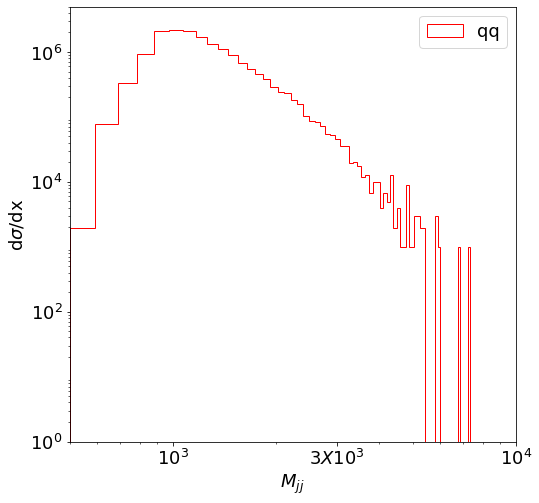

In [39]:
bins = 100
fs=18 # front size
tagsize = 18 # label tag size ((\blue block) W \n (\orange block) QCD )
plt.figure(figsize=(8,8)) # plotsize
x1, x2 = 500, 10000

bisize = np.linspace(500,10000,101)


# plt.hist(m_inv2 ,bins=bins, histtype='step',  range=[x1, x2], weights= np.array(Wc2),
#          label='rinv = 0.0, ${M_{Z}}$=1.5 TeV')
plt.hist(m_inv ,bins=bins, histtype='step', color='r', range=[x1, x2], weights= np.array(Wc),
         label='qq')

  
plt.legend(prop={'size': tagsize}) # plot label tag
plt.yscale('log')
plt.xscale('log')
plt.xlabel('${M_{jj}}$' , fontsize=fs)  # plot x-axis label
plt.ylabel("d${\sigma}$/dx", fontsize=fs)  # plot y-axis label $\u03C3^{-1}$
plt.ylim((0,5000000))
plt.xlim((x1,x2))
plt.xticks([1000,3000,10000], ['${10^3}$', '3${X}$${10^{3}}$','${10^{4}}$' ],fontsize=fs)   # set x-ticks size
plt.yticks([1,100,10000,1000000],fontsize=fs)   # set y-ticks size 
# plt.savefig("./invariant_mass_JET_SVJ_Z1500.png")  #save figure as png  
plt.show() 

# Backup

# CMS card Setting
module FastJetFinder FatJetFinder {
  set InputArray EFlowMerger/eflow

  set OutputArray jets

<!--   # algorithm: 1 CDFJetClu, 2 MidPoint, 3 SIScone, 4 kt, 5 Cambridge/Aachen, 6 antikt -->
  set JetAlgorithm 6
  set ParameterR 0.8

  set ComputeNsubjettiness 1
  set Beta 1.0
  set AxisMode 4

  set ComputeTrimming 1
  set RTrim 0.2
  set PtFracTrim 0.05

  set ComputePruning 1
  set ZcutPrun 0.1
  set RcutPrun 0.5
  set RPrun 0.8

  set ComputeSoftDrop 1
  set BetaSoftDrop 0.0
  set SymmetryCutSoftDrop 0.1
  set R0SoftDrop 0.8

  set JetPTMin 200.0
}


In [222]:
def generate_samples(gen_type='qcd', n=10, pt_cut=None, excess_factor=None, debug=False, recalculate=False):
    assert pt_cut is None or pt_cut in (
        'low', 'high'), f'invalid pt_cut={pt_cut}'
    pythia_config = get_pythia_config(gen_type, pt_cut)
    filename = get_filename(gen_type, n, pt_cut)
    if excess_factor is None and pt_cut is not None:
        excess_factor = 1.5
    else:
        excess_factor = 1
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    if not recalculate and os.path.exists(filename):
        if debug:
            print(f'Loading samples from file {filename}')
        return pd.read_pickle(filename)

    start = time.time()
    print(f'Generating {gen_type} with {excess_factor*n} events.')
    assert gen_type == 'qcd' or gen_type == 'higgs', f'gen_type must be one of [qcd, higgs] but was {gen_type}.'

    pythia = Pythia(config=pythia_config, random_state=1)

    final_jets = []
    for event in progressbar.progressbar(pythia(events=excess_factor*n), max_value=excess_factor*n):

        # Run jet finding.
        jets = pyjet.cluster(event.all((STATUS == 1) & (STATUS == 1)), R=1.0,
                             p=-1, ep=True).inclusive_jets()

        found_jet = None

        if gen_type == 'higgs':
            seen_higgs = False
            # If we are generating Higgs, we need to save where they went.
            for particle in event.all(PDG_ID == 25, return_hepmc=True):
                parents = particle.parents()
                if parents.size > 0 and parents[0]['pdgid'] == 5100039:
                    if not seen_higgs or particle.pt > higgs.pt:
                        higgs = particle
                        seen_higgs = True

            if not seen_higgs:
                continue

            for jet in jets[:4]:
                dR = CalcDeltaR(jet, higgs)
                if dR < 1.0:
                    if debug:
                        print('Found Higgs Jet')
                    found_jet = jet
        else:
            found_jet = jets[0]

        if found_jet is None:
            continue

        if debug:
            print(found_jet)

        # Calculating the ECF functions for two subjettiness
        ee2 = CalcEECorr(found_jet, n=2, beta=1.0)
        ee3 = CalcEECorr(found_jet, n=3, beta=1.0)
        d2 = ee3/ee2**3

        angularity = calc_angularity(found_jet)

        t1 = tn(found_jet, n=1)
        t2 = tn(found_jet, n=2)
        t3 = tn(found_jet, n=3)
        t21 = t2 / t1 if t1 > 0.0 else 0.0
        t32 = t3 / t2 if t2 > 0.0 else 0.0

        KtDeltaR = calc_KtDeltaR(found_jet)

        final_jets.append([found_jet.pt, found_jet.eta,
                           found_jet.phi, found_jet.mass, ee2, ee3, d2, angularity, t1, t2, t3, t21, t32, KtDeltaR])

    # Save the final jets to a file.
    final_jets = pd.DataFrame(data=final_jets, columns=[
                              'pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1', 't2', 't3', 't21', 't32', 'KtDeltaR'])
    if pt_cut is not None:
        final_jets = final_jets[(final_jets['pt'] > pt_min)
                                & (final_jets['pt'] < pt_max)]
        if final_jets.shape[0] < n:
            raise RuntimeError(
                f'excess factor was insufficient, less than {n} events ({final_jets.shape[0]}) were generated satisfying specified pt cut.')
        final_jets = final_jets[:n]
        final_jets.reset_index(inplace=True, drop=True)
    final_jets.to_pickle(filename)

    print("==========================")
    print("DONE WITH GENERATION - returning")
    print(f'Total time = {time.time() - start}')
    print("==========================")

    return final_jets

(array([  0.91819775,   0.64038521,   0.93822312,   5.5732069 ,
          1.37218153,   2.25642776,  10.74948692,   4.98437262,
          0.38311908,   0.40474677,   7.28582668,   3.39297366,
          3.78422451,   0.93220305,   0.64937967,   9.7439642 ,
          7.89991856,  13.31914997,   1.78918302,   6.35514975,
          1.30370355,   1.09442973,   3.81843162,   3.01032257,
          1.35108292,   1.23890626,   2.47352934,   1.75911438,
          5.21155643,  38.24241257,   0.61120105,   1.20469832,
          4.26183748,  10.82800961,   2.64965653,  93.06800079,
          0.650971  ,   4.76166105,   2.27072453,   5.55881596,
          1.33282053,  14.94717598,   2.44216084,   1.40001917,
          4.32057762,   2.57903981,   0.63378054, 272.3387146 ]),
 array([ 0.2311534 ,  0.14610601,  0.16804717, -0.02933283, -0.1168667 ,
        -0.08119907, -0.18362236, -0.30100589, -0.73737529, -0.52246382,
         0.37481695,  0.43659746,  0.27487792,  0.30066961,  0.23671226,
         0.